In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose
import plotly.graph_objects as go
from google.colab import files

In [16]:
#from google.colab import drive
#rive.mount('/content/drive')


# Update the path according to the location of your CSV file
#file_path = '/content/drive/My Drive/CC GENERAL.csv'
a = pd.read_csv('CC GENERAL.csv').dropna()





       BALANCE  PURCHASES  CREDIT_LIMIT CREDIT_CARD_SEGMENTS  \
0    40.900749      95.40        1000.0            Cluster 2   
1  3202.467416       0.00        7000.0            Cluster 4   
2  2495.148862     773.17        7500.0            Cluster 4   
4   817.714335      16.00        1200.0            Cluster 2   
5  1809.828751    1333.28        1800.0            Cluster 2   

     PRODUCT_RECOMMENDATION  
0            Review Options  
1  Low-Interest Credit Card  
2       Travel Rewards Card  
4            Review Options  
5            Review Options  


Predicted future purchases: $3245.31
       BALANCE  PURCHASES  CREDIT_LIMIT ANOMALY
0    40.900749      95.40        1000.0  Normal
1  3202.467416       0.00        7000.0  Normal
2  2495.148862     773.17        7500.0  Normal
4   817.714335      16.00        1200.0  Normal
5  1809.828751    1333.28        1800.0  Normal
       BALANCE  PURCHASES  CREDIT_LIMIT FRAUD_STATUS
0    40.900749      95.40        1000.0     No Fraud
1  3202.467416       0.00        7000.0     No Fraud
2  2495.148862     773.17        7500.0     No Fraud
4   817.714335      16.00        1200.0     No Fraud
5  1809.828751    1333.28        1800.0     No Fraud


Text(0.5, 0.98, 'Seasonal Decomposition of Purchases')

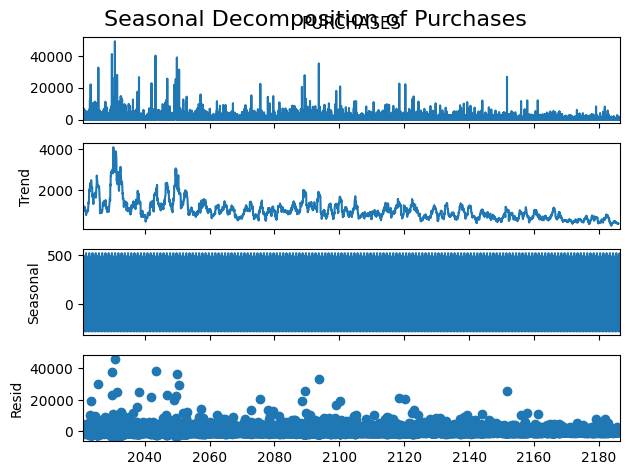

In [17]:
# Select relevant features for clustering
data = a[["BALANCE", "PURCHASES", "CREDIT_LIMIT"]]

# Scale the data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Perform clustering with KMeans
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(data_scaled)

# Add cluster results to the original data
a["CREDIT_CARD_SEGMENTS"] = clusters
a["CREDIT_CARD_SEGMENTS"] = a["CREDIT_CARD_SEGMENTS"].map(
    {0: "Cluster 1", 1: "Cluster 2", 2: "Cluster 3", 3: "Cluster 4", 4: "Cluster 5"}
)

# -------------------- Recommendation System --------------------
def recommend_products(balance, purchases, credit_limit):
    """Simple recommendation logic based on spending patterns."""
    if purchases > balance * 0.8:
        return "Cashback Credit Card"
    elif credit_limit > balance * 3:
        return "Travel Rewards Card"
    else:
        return "Low-Interest Credit Card"

# Apply recommendations to all customers
a["PRODUCT_RECOMMENDATION"] = a.apply(
    lambda x: recommend_products(x["BALANCE"], x["PURCHASES"], x["CREDIT_LIMIT"]), axis=1
)

# -------------------- Feedback Loop --------------------
def update_recommendation(user_feedback, customer_data):
    """Update recommendations based on user feedback."""
    # Example feedback: user_feedback is a DataFrame with columns ['CREDIT_CARD_SEGMENTS', 'FEEDBACK']
    for index, row in user_feedback.iterrows():
        segment = row['CREDIT_CARD_SEGMENTS']
        if row['FEEDBACK'] == 'Positive':
            # Optionally enhance recommendations for this segment
            continue
        elif row['FEEDBACK'] == 'Negative':
            # Adjust recommendations logic
            # For example, exclude this product from future recommendations
            a.loc[a['CREDIT_CARD_SEGMENTS'] == segment, 'PRODUCT_RECOMMENDATION'] = 'Review Options'

# Example user feedback data
user_feedback = pd.DataFrame({
    'CREDIT_CARD_SEGMENTS': ['Cluster 1', 'Cluster 2'],
    'FEEDBACK': ['Positive', 'Negative']
})
update_recommendation(user_feedback, a)

# -------------------- Display Recommendations in a Table --------------------
recommendation_table = a[["BALANCE", "PURCHASES", "CREDIT_LIMIT",
                          "CREDIT_CARD_SEGMENTS", "PRODUCT_RECOMMENDATION"]]

print(recommendation_table.head())  # Print table to console

# -------------------- Interactive 3D Plot with Recommendations --------------------
plot = go.Figure()

for segment in a["CREDIT_CARD_SEGMENTS"].unique():
    segment_data = a[a["CREDIT_CARD_SEGMENTS"] == segment]

    plot.add_trace(go.Scatter3d(
        x=segment_data["BALANCE"],
        y=segment_data["PURCHASES"],
        z=segment_data["CREDIT_LIMIT"],
        mode='markers',
        marker=dict(size=6, line=dict(width=1)),
        name=f"{segment} - {segment_data['PRODUCT_RECOMMENDATION'].iloc[0]}"
    ))

# Update plot layout
plot.update_traces(
    hovertemplate=(
        'BALANCE: %{x}<br>'
        'PURCHASES: %{y}<br>'
        'CREDIT_LIMIT: %{z}<br>'
    )
)
plot.update_layout(
    width=800, height=800, autosize=True, showlegend=True,
    scene=dict(
        xaxis=dict(title='BALANCE', titlefont_color='black'),
        yaxis=dict(title='PURCHASES', titlefont_color='black'),
        zaxis=dict(title='CREDIT_LIMIT', titlefont_color='black')
    ),
    font=dict(family="Gilroy", color='black', size=12)
)

# Show the 3D plot
plot.show()

# -------------------- Predictive Model --------------------
# Train a Linear Regression model to predict future purchases
X = a[["BALANCE", "CREDIT_LIMIT"]]
y = a["PURCHASES"]
model = LinearRegression()
model.fit(X, y)

# Predict future purchases for a sample customer
new_data = pd.DataFrame([[5000, 15000]], columns=["BALANCE", "CREDIT_LIMIT"])
predicted_purchase = model.predict(new_data)
print(f"Predicted future purchases: ${predicted_purchase[0]:.2f}")

# -------------------- Anomaly Detection --------------------
anomaly_detector = IsolationForest(contamination=0.05, random_state=42)
a["ANOMALY"] = anomaly_detector.fit_predict(data_scaled)
a["ANOMALY"] = a["ANOMALY"].map({1: "Normal", -1: "Anomaly"})

print(a[["BALANCE", "PURCHASES", "CREDIT_LIMIT", "ANOMALY"]].head())

# -------------------- Fraud Detection --------------------
# Simple fraud detection logic
def detect_fraud(row):
    if row["ANOMALY"] == "Anomaly":
        return "Fraud Alert"
    return "No Fraud"

a["FRAUD_STATUS"] = a.apply(detect_fraud, axis=1)
print(a[["BALANCE", "PURCHASES", "CREDIT_LIMIT", "FRAUD_STATUS"]].head())

# -------------------- Time Series Analysis --------------------
if 'DATE' not in a.columns:
    a['DATE'] = pd.date_range(start='2021-01-01', periods=len(a), freq='W')

# Decompose time series for analysis
result = seasonal_decompose(a.set_index('DATE')['PURCHASES'], model='additive', period=52)
result.plot().suptitle('Seasonal Decomposition of Purchases', fontsize=16)


